In [14]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import time
from IPython.display import display, HTML
import pandas as pd

# Constants
L1, L2, L3 = 1.0, 1.5, 0.5  # link lengths

@tf.function
def forward_kinematics_tf(theta):
    theta1, theta2, theta3 = tf.unstack(theta, axis=1)
    
    x = L1 * tf.cos(theta1) * tf.sin(theta2) + L2 * tf.cos(theta1) * tf.sin(theta2 + theta3)
    y = L1 * tf.sin(theta1) * tf.sin(theta2) + L2 * tf.sin(theta1) * tf.sin(theta2 + theta3)
    z = L1 * tf.cos(theta2) + L2 * tf.cos(theta2 + theta3) + L3
    
    return tf.stack([x, y, z], axis=1)

def evaluate_model(model, test_inputs, test_outputs, input_mean, input_std, batch_size=2**16):
    # Convert numpy arrays to TensorFlow tensors
    test_inputs = tf.convert_to_tensor(test_inputs, dtype=tf.float32)
    input_mean = tf.convert_to_tensor(input_mean, dtype=tf.float32)
    input_std = tf.convert_to_tensor(input_std, dtype=tf.float32)

    # Predict in batches
    predicted_angles_normalized = model.predict(test_inputs, batch_size=batch_size)
    predicted_angles = predicted_angles_normalized * (np.pi/2)

    # Use TensorFlow operations for the rest of the computations
    true_xyz = test_inputs * input_std + input_mean
    predicted_xyz = forward_kinematics_tf(predicted_angles)

    # Compute errors
    errors = tf.norm(true_xyz - predicted_xyz, axis=1)

    return errors.numpy(), true_xyz.numpy(), predicted_xyz.numpy()

def custom_loss(fk_weight=1):
    def loss_fn(y_true, y_pred):
        # MSE loss for joint angles
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
        
        # Forward kinematics loss
        fk_true = forward_kinematics_tf(y_true)
        fk_pred = forward_kinematics_tf(y_pred)
        fk_loss = tf.reduce_mean(tf.square(fk_true - fk_pred))
        
        # Combine losses
        total_loss = mse_loss + fk_weight * fk_loss
        return total_loss
    return loss_fn

def display_results(results):
    data = []
    for name, result in results.items():
        data.append({
            'Model': name,
            'Mean Error': f"{np.mean(result['errors']):.4f}",
            'Median Error': f"{np.median(result['errors']):.4f}",
            '90th Percentile Error': f"{np.percentile(result['errors'], 90):.4f}",
            'Max Error': f"{np.max(result['errors']):.4f}",
            'Training Time (s)': f"{result['training_time']:.2f}"
        })
    
    df = pd.DataFrame(data)
    df = df.set_index('Model')
    
    # Style the dataframe
    styled_df = df.style.set_properties(**{'text-align': 'center'})
    styled_df = styled_df.set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]},
        {'selector': 'td', 'props': [('text-align', 'center')]}
    ])
    
    # Display the styled dataframe
    display(HTML(styled_df.to_html()))

def create_model(loss_type='standard'):
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=(3,)),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(3, activation='tanh')  # tanh to keep output in [-1, 1]
    ])
    
    if loss_type == 'standard':
        model.compile(optimizer='adam', loss='mse')
    elif loss_type == 'custom':
        model.compile(optimizer='adam', loss=custom_loss())
    elif loss_type == 'modified_custom':
        model.compile(optimizer='adam', loss=custom_loss(fk_weight=10))
    
    return model

def load_and_preprocess_data(filename='robot_arm_dataset_10M.npz'):
    data = np.load(f'./Data/{filename}')
    inputs, outputs = data['inputs'], data['outputs']
    
    # Normalize inputs (end-effector positions)
    input_mean = np.mean(inputs, axis=0)
    input_std = np.std(inputs, axis=0)
    inputs_normalized = (inputs - input_mean) / input_std

    # Normalize outputs (joint angles) to [-1, 1]
    outputs_normalized = outputs / (np.pi/2)

    # Split data into train and test sets
    split_index = int(0.9 * len(inputs))
    train_inputs, test_inputs = inputs_normalized[:split_index], inputs_normalized[split_index:]
    train_outputs, test_outputs = outputs_normalized[:split_index], outputs_normalized[split_index:]

    return (train_inputs, train_outputs), (test_inputs, test_outputs), input_mean, input_std

def train_model(model, train_data, valid_data, epochs=50, batch_size=2**16):
    train_inputs, train_outputs = train_data
    valid_inputs, valid_outputs = valid_data
    
    history = model.fit(
        train_inputs, train_outputs,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(valid_inputs, valid_outputs),
        callbacks=[
            keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
        ]
    )
    
    return model, history

def plot_error_distribution(errors_dict):
    plt.figure(figsize=(12, 6))
    for name, errors in errors_dict.items():
        plt.hist(errors, bins=100, alpha=0.5, label=name)
    plt.title('Error Distribution Comparison')
    plt.xlabel('Error (Euclidean distance)')
    plt.ylabel('Frequency')
    plt.xlim([0, 1.5])
    plt.legend()
    plt.show()

def plot_training_history(history_dict):
    plt.figure(figsize=(12, 6))
    for name, history in history_dict.items():
        plt.plot(history.history['loss'], label=f'{name} - Training')
        plt.plot(history.history['val_loss'], label=f'{name} - Validation')
    plt.title('Training History Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_true_vs_predicted(true_xyz, predicted_xyz, title):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(title)
    
    for i, coord in enumerate(['X', 'Y', 'Z']):
        ax = axes[i]
        ax.scatter(true_xyz[:, i], predicted_xyz[:, i], alpha=0.1)
        ax.plot([true_xyz[:, i].min(), true_xyz[:, i].max()], [true_xyz[:, i].min(), true_xyz[:, i].max()], 'r--')
        ax.set_xlabel(f'True {coord}')
        ax.set_ylabel(f'Predicted {coord}')
        ax.set_title(f'{coord} Coordinate: True vs Predicted')
    
    plt.tight_layout()
    plt.show()

In [2]:
(train_inputs, train_outputs), (test_inputs, test_outputs), input_mean, input_std = load_and_preprocess_data()


models = {
    'Standard Loss': create_model('standard'),
    'Custom Loss': create_model('custom'),
    'Modified Custom Loss': create_model('modified_custom')
}

results = {}
    
for name, model in models.items():
    start_time = time.time()
    trained_model, history = train_model(model, (train_inputs, train_outputs), (test_inputs, test_outputs), epochs=50)
    errors, true_xyz, predicted_xyz = evaluate_model(trained_model, test_inputs, test_outputs, input_mean, input_std)
    training_time = time.time() - start_time

    results[name] = {
        'model': trained_model,
        'history': history,
        'errors': errors,
        'true_xyz': true_xyz,
        'predicted_xyz': predicted_xyz,
        'training_time': training_time
    }

    # Print summary statistics
    print(f"\n{name} Model:")
    print(f"Mean Error: {np.mean(errors):.4f}")
    print(f"Median Error: {np.median(errors):.4f}")
    print(f"90th Percentile Error: {np.percentile(errors, 90):.4f}")
    print(f"Max Error: {np.max(errors):.4f}")
    print(f"Training Time: {training_time:.2f} seconds")

Epoch 1/50
138/138 [==============================] - 2s 10ms/step - loss: 0.1290 - val_loss: 0.1056 - lr: 0.0010
Epoch 2/50
138/138 [==============================] - 1s 9ms/step - loss: 0.0953 - val_loss: 0.0892 - lr: 0.0010
Epoch 3/50
138/138 [==============================] - 1s 8ms/step - loss: 0.0878 - val_loss: 0.0879 - lr: 0.0010
Epoch 4/50
138/138 [==============================] - 1s 8ms/step - loss: 0.0866 - val_loss: 0.0866 - lr: 0.0010
Epoch 5/50
138/138 [==============================] - 1s 8ms/step - loss: 0.0859 - val_loss: 0.0863 - lr: 0.0010
Epoch 6/50
138/138 [==============================] - 1s 8ms/step - loss: 0.0855 - val_loss: 0.0853 - lr: 0.0010
Epoch 7/50
138/138 [==============================] - 1s 8ms/step - loss: 0.0851 - val_loss: 0.0851 - lr: 0.0010
Epoch 8/50
138/138 [==============================] - 1s 8ms/step - loss: 0.0848 - val_loss: 0.0849 - lr: 0.0010
Epoch 9/50
138/138 [==============================] - 1s 8ms/step - loss: 0.0845 - val_loss: 0.

Epoch 20/50
138/138 [==============================] - 1s 9ms/step - loss: 0.0870 - val_loss: 0.0872 - lr: 5.0000e-04
Epoch 21/50
138/138 [==============================] - 1s 9ms/step - loss: 0.0871 - val_loss: 0.0872 - lr: 5.0000e-04
Epoch 22/50
138/138 [==============================] - 1s 9ms/step - loss: 0.0870 - val_loss: 0.0872 - lr: 5.0000e-04
Epoch 23/50
138/138 [==============================] - 1s 9ms/step - loss: 0.0871 - val_loss: 0.0871 - lr: 5.0000e-04
Epoch 24/50
138/138 [==============================] - 1s 8ms/step - loss: 0.0867 - val_loss: 0.0868 - lr: 2.5000e-04
Epoch 25/50
138/138 [==============================] - 1s 9ms/step - loss: 0.0867 - val_loss: 0.0869 - lr: 2.5000e-04
Epoch 26/50
138/138 [==============================] - 1s 9ms/step - loss: 0.0867 - val_loss: 0.0869 - lr: 2.5000e-04
Epoch 27/50
138/138 [==============================] - 1s 9ms/step - loss: 0.0867 - val_loss: 0.0868 - lr: 2.5000e-04
Epoch 28/50
138/138 [==============================] - 1

138/138 [==============================] - 1s 9ms/step - loss: 0.0992 - val_loss: 0.1000 - lr: 1.2500e-04
Epoch 39/50
138/138 [==============================] - 1s 9ms/step - loss: 0.0992 - val_loss: 0.0993 - lr: 1.2500e-04
Epoch 40/50
138/138 [==============================] - 1s 9ms/step - loss: 0.0990 - val_loss: 0.0992 - lr: 6.2500e-05
Epoch 41/50
138/138 [==============================] - 1s 9ms/step - loss: 0.0990 - val_loss: 0.0992 - lr: 6.2500e-05
Epoch 42/50
138/138 [==============================] - 1s 9ms/step - loss: 0.0990 - val_loss: 0.0992 - lr: 6.2500e-05
Epoch 43/50
138/138 [==============================] - 1s 9ms/step - loss: 0.0990 - val_loss: 0.0991 - lr: 6.2500e-05
Epoch 44/50
138/138 [==============================] - 1s 9ms/step - loss: 0.0989 - val_loss: 0.0993 - lr: 6.2500e-05
Epoch 45/50
138/138 [==============================] - 1s 9ms/step - loss: 0.0989 - val_loss: 0.0991 - lr: 3.1250e-05
Epoch 46/50
138/138 [==============================] - 1s 9ms/step -

In [6]:
for name, result in results.items():
    print(f"\n{name} Model:")
    print(f"Mean Error: {np.mean(result['errors']):.4f}")
    print(f"Median Error: {np.median(result['errors']):.4f}")
    print(f"90th Percentile Error: {np.percentile(result['errors'], 90):.4f}")
    print(f"Max Error: {np.max(result['errors']):.4f}")
    print(f"Training Time: {result['training_time']:.2f} seconds")


Standard Loss Model:
Mean Error: 0.1533
Median Error: 0.0754
90th Percentile Error: 0.4352
Max Error: 4.1045
Training Time: 59.69 seconds

Custom Loss Model:
Mean Error: 0.1462
Median Error: 0.0614
90th Percentile Error: 0.4340
Max Error: 4.0741
Training Time: 61.60 seconds

Modified Custom Loss Model:
Mean Error: 0.1435
Median Error: 0.0580
90th Percentile Error: 0.4319
Max Error: 3.9923
Training Time: 61.38 seconds


In [15]:
display_results(results)

,Mean Error,Median Error,90th Percentile Error,Max Error,Training Time (s)
Model,,,,,
Standard Loss,0.1533,0.0754,0.4352,4.1045,59.69
Custom Loss,0.1462,0.0614,0.4340,4.0741,61.60
Modified Custom Loss,0.1435,0.0580,0.4319,3.9923,61.38


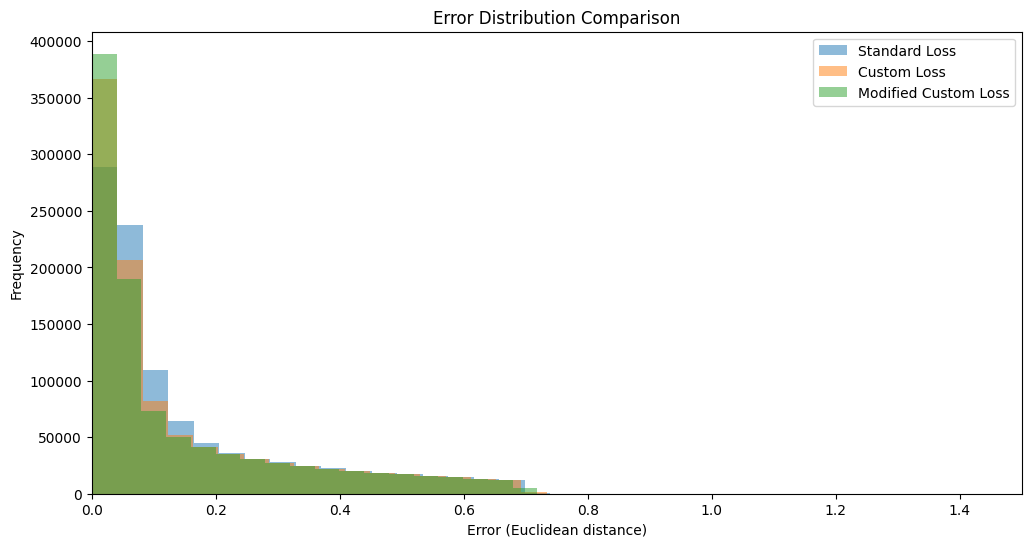

In [3]:
# Plot error distribution comparison
plot_error_distribution({name: result['errors'] for name, result in results.items()})

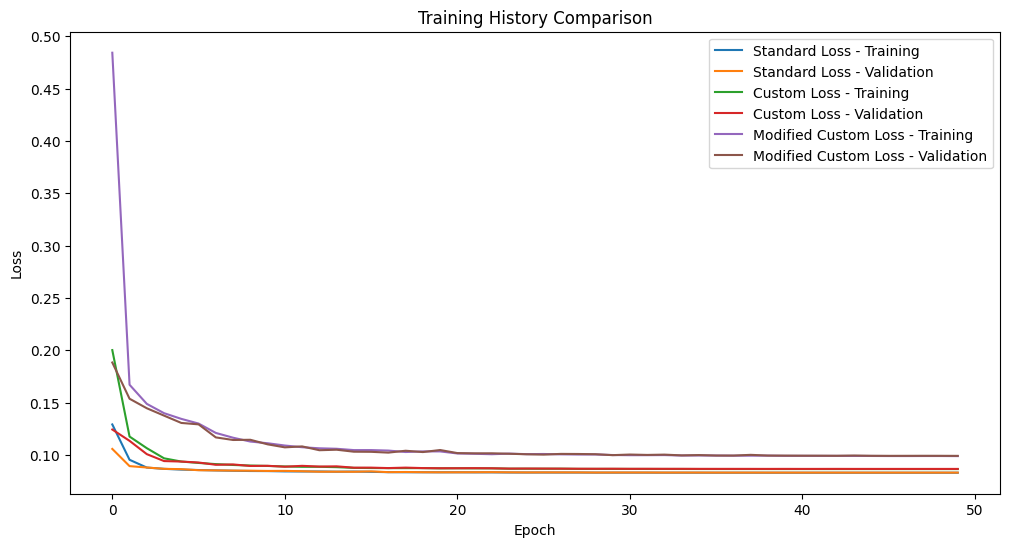

In [4]:
# Plot training history comparison
plot_training_history({name: result['history'] for name, result in results.items()})

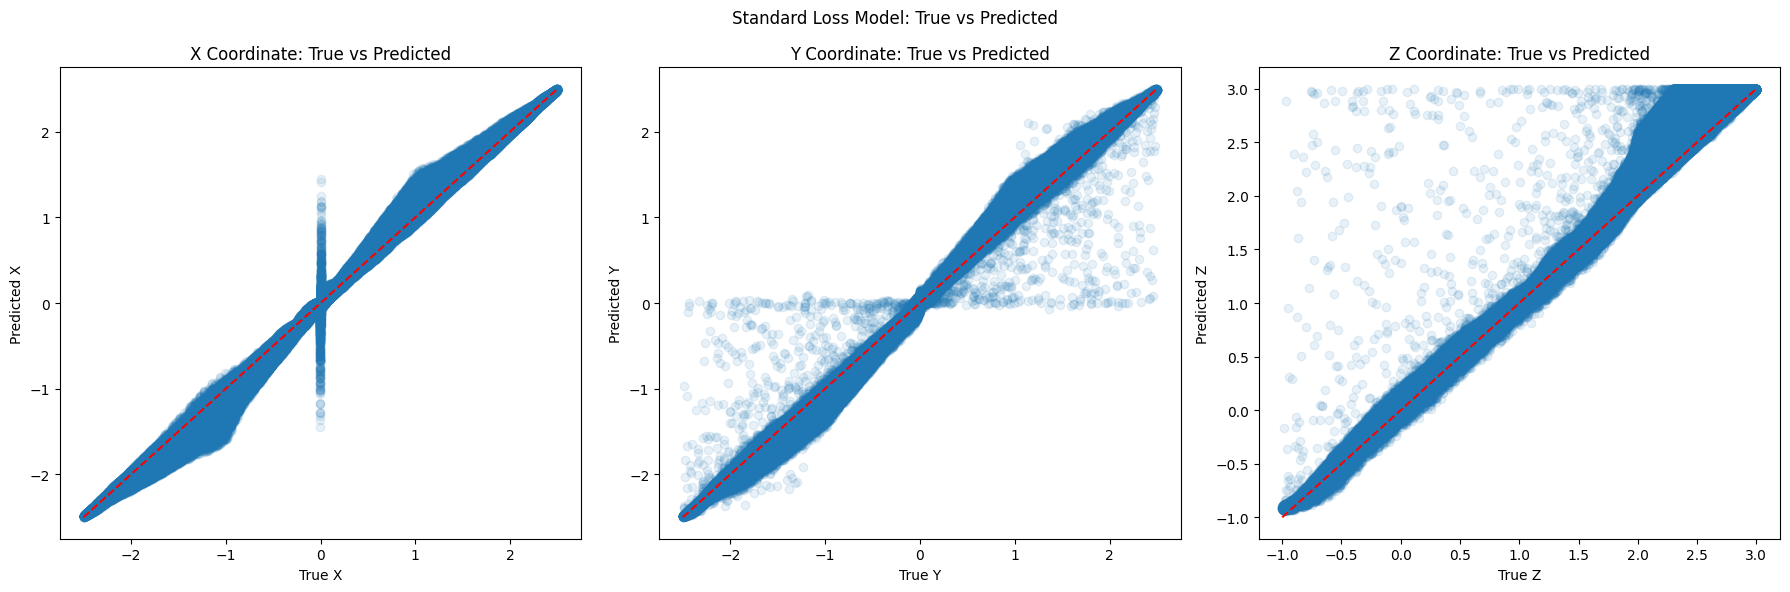

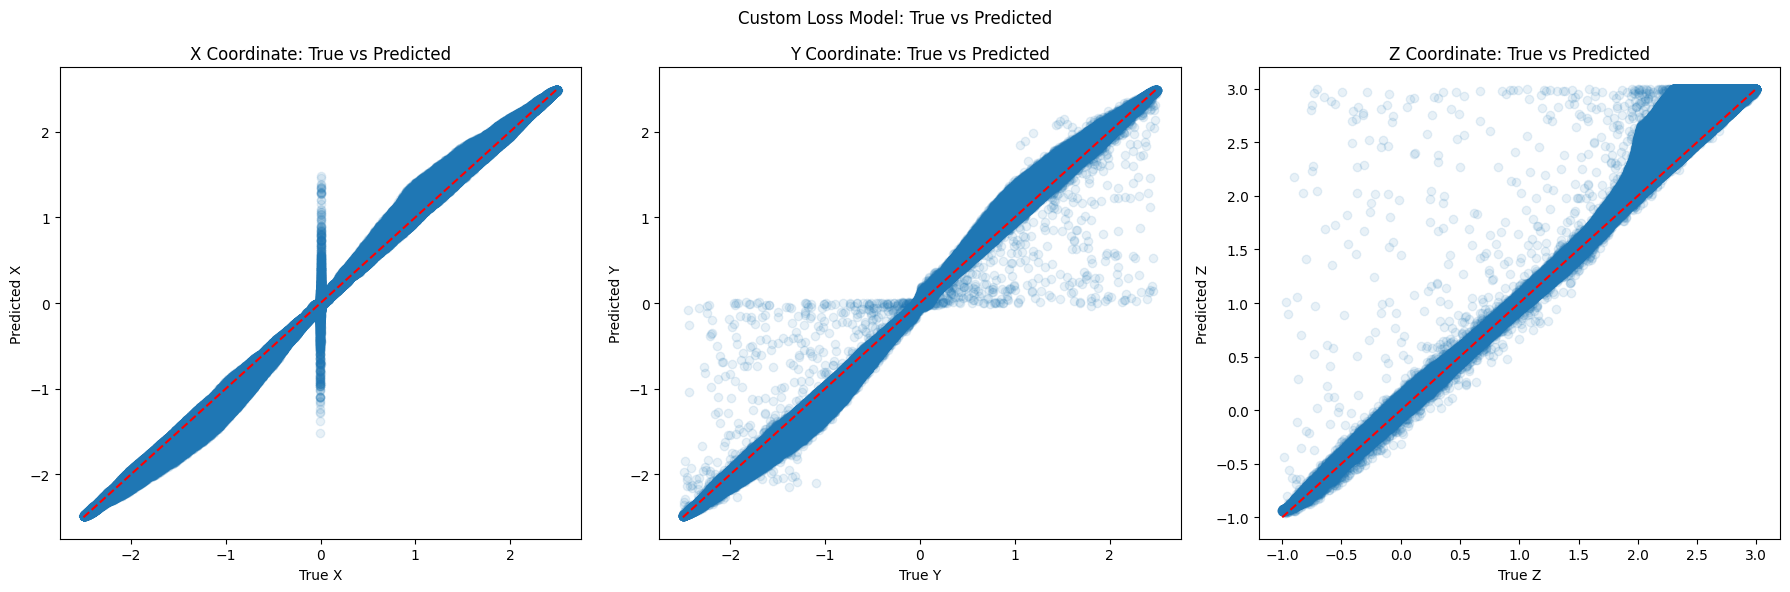

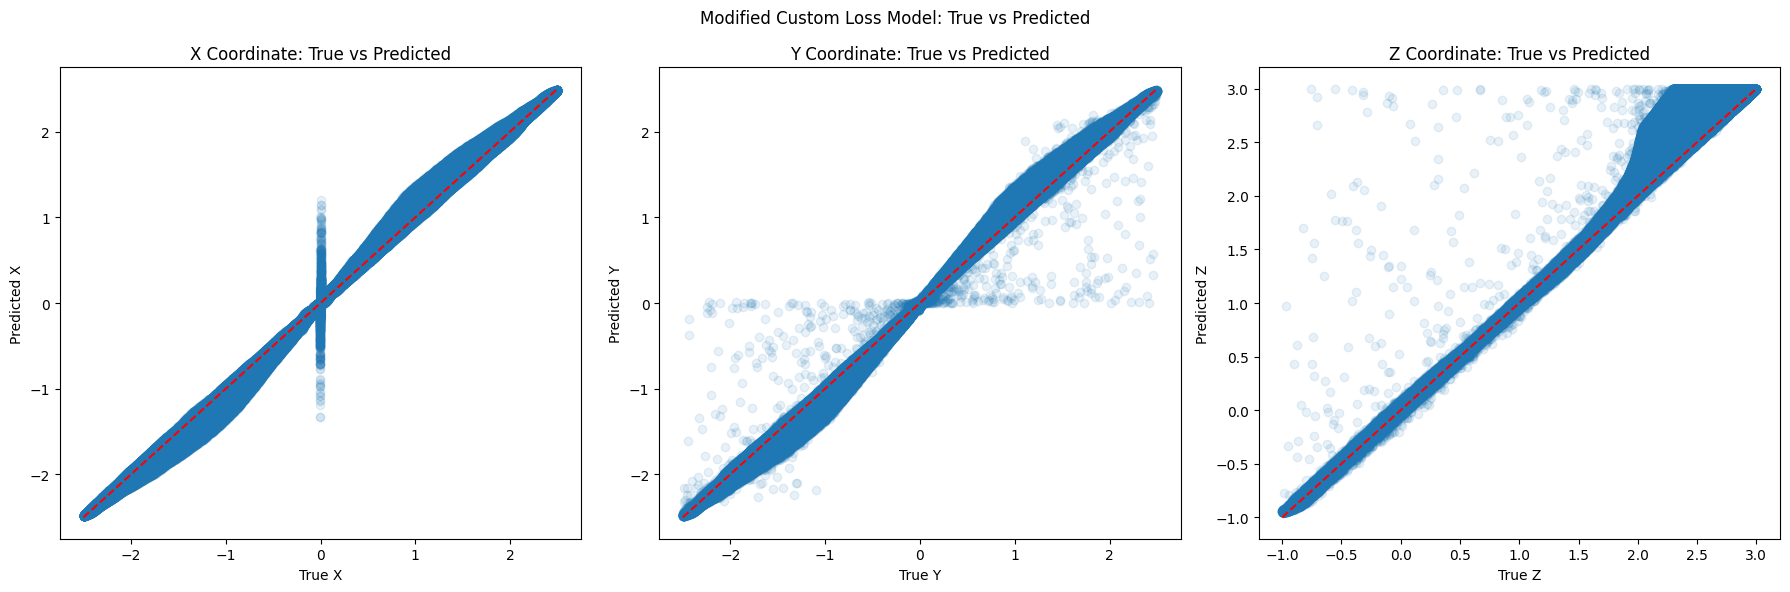

In [5]:
# Plot true vs predicted values for each model
for name, result in results.items():
    plot_true_vs_predicted(result['true_xyz'], result['predicted_xyz'], f"{name} Model: True vs Predicted")